In [7]:
import pandas as pd
# Cargar los datos
file_path = '/home/hidrologia/esmeraldas/merged_2019-01-01_2024-03-26.csv'
data = pd.read_csv(file_path)

data_nonans = data.dropna()
data_nonans.head()

,Unnamed: 0,60,111,112,113,114,162,163,164,165,...,2576,2577,2627,2628,2629,2679,2680,hidro_level_m1,precip_acumu_sm,hidro_level_sm
11542,2023-02-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.32,0.00,5.60
11543,2023-02-01 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.41,0.00,5.64
11544,2023-02-01 06:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.06,0.00,6.43
11545,2023-02-01 09:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.87,0.00,7.10
11546,2023-02-01 12:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.39,0.65,7.58


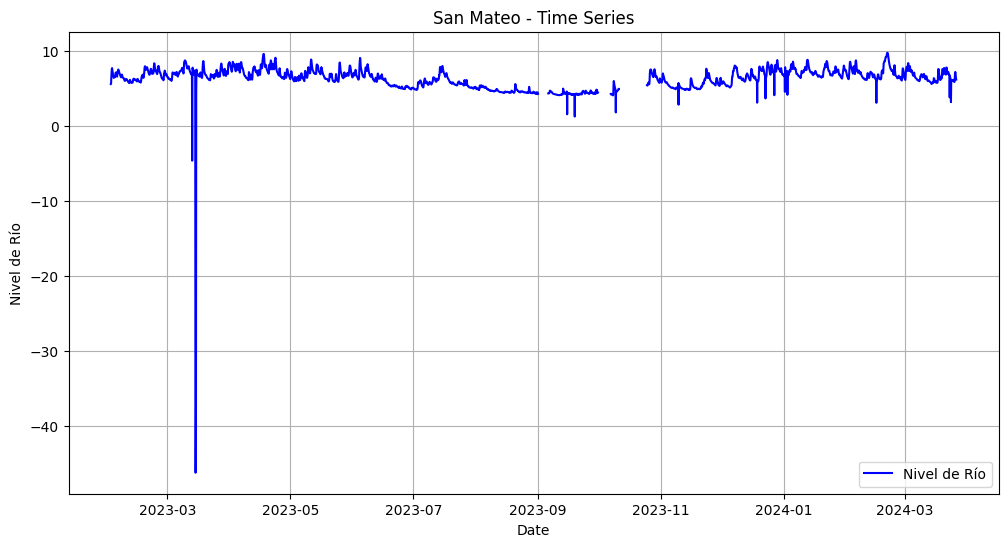

In [8]:
import matplotlib.pyplot as plt

# Convertir la columna de tiempo a formato datetime
data['Unnamed: 0'] = pd.to_datetime(data['Unnamed: 0'])
data = data.set_index('Unnamed: 0')

# Visualizar la serie temporal de hidro_level_sm
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['hidro_level_sm'], label='Nivel de Río', color='blue')
plt.title('San Mateo - Time Series')
plt.xlabel('Date')
plt.ylabel('Nivel de Río')
plt.legend()
plt.grid(True)
plt.show()

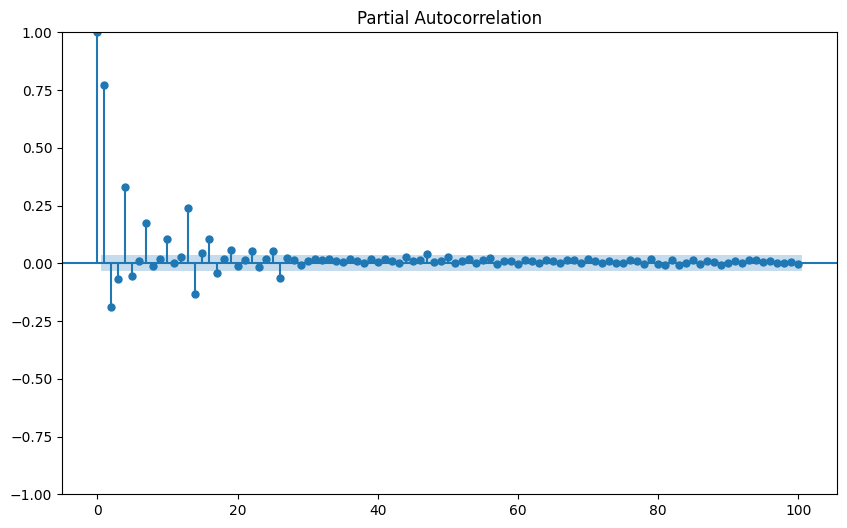

In [35]:
import pandas as pd
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as plt
df_first_date = pd.read_csv('/home/hidrologia/esmeraldas/merged_2019-01-01_2024-03-26 (copy).csv')
# DROP NaNs values for this analysis
df_first_date.dropna(subset=['hidro_level_sm'], inplace=True)
df_first_date = df_first_date.set_index('date')
#df_first_date = df_first_date[df_first_date['hidro_level_sm'] >= 0]

"""# Check for drops greater than 3.5 and remove those rows
df_first_date['hidro_level_sm_shift'] = df_first_date['hidro_level_sm'].shift(1)
df_first_date['hidro_level_sm_diff'] = df_first_date['hidro_level_sm'] - df_first_date['hidro_level_sm_shift']
df_first_date = df_first_date[df_first_date['hidro_level_sm_diff'] > -2.8]
df_first_date.drop(['hidro_level_sm_shift', 'hidro_level_sm_diff'], axis=1, inplace=True)
"""
# PACF plot to determine the optimal number of lags
discharge_series = df_first_date['hidro_level_sm']
fig, ax = plt.subplots(figsize=(10, 6))
plot_pacf(discharge_series, ax=ax, lags=100)  

import plotly.express as px
# Now create the Plotly line chart
fig = px.line(df_first_date, x=df_first_date.index, y='hidro_level_sm', 
              title='San Mateo - Time Series', labels={'hidro_level_sm':'Nivel de Río'})

# Customize the layout
fig.update_layout(
    xaxis_title="Date",
    yaxis_title="Nivel de Río",
    legend_title="Legend",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="RebeccaPurple"
    )
)

# To display the figure in an interactive window (like Jupyter Notebook/Google Colab),
# simply use fig.show().
fig.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt

# Function to calculate Nash-Sutcliffe Efficiency
def nse(observed, simulated):
    return 1 - sum((simulated-observed)**2)/sum((observed-np.mean(observed))**2)

# Function to calculate Kling-Gupta Efficiency
def kge(observed, simulated):
    r = np.corrcoef(observed, simulated)[0, 1]
    alpha = np.std(simulated) / np.std(observed)
    beta = np.sum(simulated) / np.sum(observed)
    return 1 - np.sqrt((r-1)**2 + (alpha-1)**2 + (beta-1)**2)

def create_lagged_features(df, column_name, max_lag):
    for lag in range(1, max_lag + 1):
        df[f'{column_name}_lag_{lag}'] = df[column_name].shift(lag)
    return df

#roling average
df_first_date['Discharge_rolling_avg'] = df_first_date['Discharge'].rolling(window=3, min_periods=1).mean()
# Choose a lag value
max_lag = 3  # For example, you can use a lag of 3 time steps

# Create lagged features for the 'Discharge' column
df_first_date = create_lagged_features(df_first_date, 'Discharge', max_lag)

# Drop rows with NaN values that were created by shifting to create lagged features
df_first_date = df_first_date.dropna()

# Preparing data
X = df_first_date.drop(columns=['date', 'Discharge'])
y = df_first_date['Discharge']
dates = df_first_date['date']

# Splitting data (70% training, 30% testing) sequentially
split_index = int(len(X) * 0.7)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]
dates_train, dates_test = dates[:split_index], dates[split_index:]

# Training the Random Forest model
model = RandomForestRegressor(
    n_estimators=150,  # Increased from 100 for potentially better performance
    max_depth=20,  # Adjust as needed based on the complexity of your data
    min_samples_split=10,  # Helps to prevent overfitting on minor details
    min_samples_leaf=5,  # Ensures that leaves have a minimum number of samples
    #max_features='sqrt',  # Auto setting for regression typically uses all features, consider "sqrt" or "log2" for high-dimensional data
    bootstrap=True,  # Keep bootstrap sampling to True for general usage
    n_jobs = -2
)
model.fit(X_train, y_train)

# Predicting discharge
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calculating metrics
nse_train = nse(y_train, y_train_pred)
nse_test = nse(y_test, y_test_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
kge_train = kge(y_train, y_train_pred)
kge_test = kge(y_test, y_test_pred)

# Outputting the metrics
print(f"Training NSE: {nse_train}, MSE: {mse_train}, KGE: {kge_train}")
print(f"Testing NSE: {nse_test}, MSE: {mse_test}, KGE: {kge_test}")

# Plotting observed vs. predicted discharge for training period
plt.figure(figsize=(10, 6))
plt.plot(dates_train, y_train, label='Observed', color='blue')
plt.plot(dates_train, y_train_pred, label='Simulated', color='red')
plt.title(f"Training Period: Observed vs. Simulated Discharge\nNSE: {nse_train:.2f}, MSE: {mse_train:.2f}, KGE: {kge_train:.2f}")
plt.xlabel('Date')
plt.ylabel('Discharge')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plotting observed vs. predicted discharge for testing period
plt.figure(figsize=(10, 6))
plt.plot(dates_test, y_test, label='Observed', color='blue')
plt.plot(dates_test, y_test_pred, label='Simulated', color='red')
plt.title(f"Testing Period: Observed vs. Simulated Discharge\nNSE: {nse_test:.2f}, MSE: {mse_test:.2f}, KGE: {kge_test:.2f}")
plt.xlabel('Date')
plt.ylabel('Discharge')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# TO DO

Merge the WRF precipitation csv the path is /home/hidrologia/shared_folder/carpeta-compartida-DPA/Carpetas_personales/Gissella_D/Ecuador2/prec_time_series.csv \
Addapt the script to our data
\
Grid search 
\
Random Search
\
Cross-Validation